# Inertial + Floorplan Localization Using CRF

## Paper

This implementation is based on the researches done on the following papers,

[1]	Z. Xiao, H. Wen, A. Markham, και N. Trigoni, ‘Lightweight map matching for indoor localisation using conditional random fields’, στο IPSN-14 proceedings of the 13th international symposium on information processing in sensor networks, 2014, σσ. 131–142.

[2]	J. Zhang, M. Ren, P. Wang, J. Meng, και Y. Mu, ‘Indoor localization based on VIO system and three-dimensional map matching’, Sensors, τ. 20, τχ. 10, σ. 2790, 2020.


Note that due to unavailability of exact dataset used for above researchers, I had to use following dataset and convert that accordingly.

[3] S. Herath, S. Irandoust, B. Chen, Y. Qian, P. Kim, και Y. Furukawa, ‘Fusion-DHL: WiFi, IMU, and Floorplan Fusion for Dense History of Locations in Indoor Environments’, στο 2021 IEEE International Conference on Robotics and Automation (ICRA), 2021, σσ. 5677–5683.

## Theory

In this notebook, I am going to implement indoor localization mechanism using Linear Chain Conditional Random Fields. By using this model we can predict location of a user when starting position, IMU observations (velocity vectors) and floorplan of the building is given.

Inputs,

* Stating Position - (Meters In X direction(TopLeft|LeftRight), Meters In Y direction(TopLeft|TopBottom))
* Sequence of Velocity Vectors Captured In Small Time Range (20 seconds) : Velocity_Values(ms-1), Velocity_Angles(radian)
* Graph of Floorplan


### Overall Architecture

Here is the overall system architecture

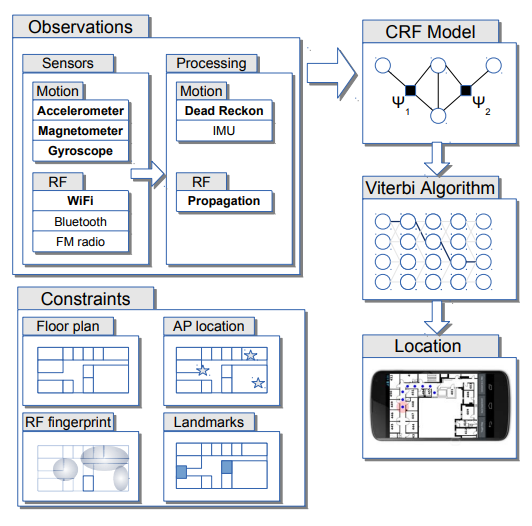

The input is a velocity vector observed using IMU data Z = {Z0,...,ZT }, and the task is to predict a sequence of states S = {S0,...,ST } given input Z.

### Viterbi Algorithm

We use Viterbi algorithm, which can dynamically solve the optimal state points sequence that is most likely to produce the currently given observation value sequence. The solution steps of Viterbi algorithm are as follows:

(1) Initialization: Compute the non-normalized probability of the first position for all states, where m is the number of states.

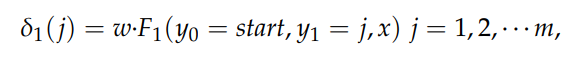

(2) Recursion: Iterate through each state from front to back, find the maximum value of the non-normalized probability of each state l = 1, 2, · · · , m at position i = 2, 3, · · · , n, and record the state sequence label Ψi(l) with the highest probability.

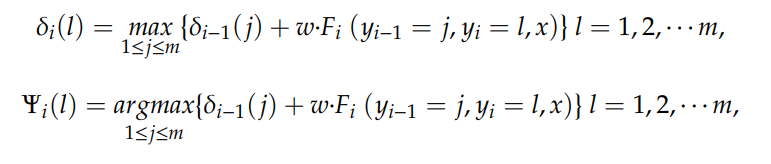

(3) When i = n, we obtain the maximum value of the non-normalized probability and the terminal
of the optimal state points sequence

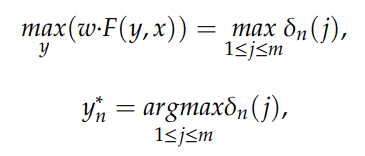

(4) Calculate the final state points output sequence

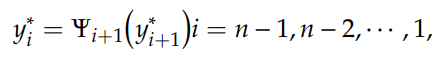

(5) Finally, the optimal sequence of state points is as follows:

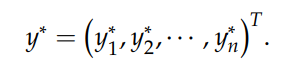

### Defined F and W

We can use w and F(y, x) to represent the weight vector and the global state transfer function vector.

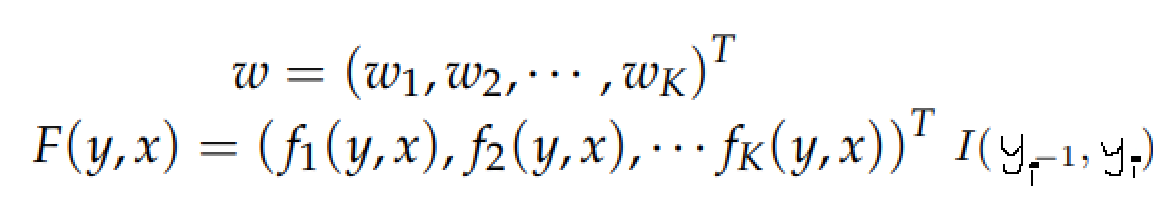

where I(Yt−1, Yt) is an indicator function equal to 1 when states Yt−1 and Yt are connected and 0 otherwise.

We use two functions f1 anf f2

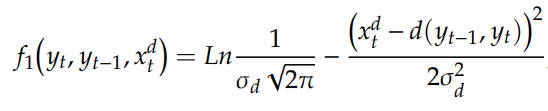

where xdt is the Euclidean distance between two consecutive observations, d(yt−1, yt) is the Euclidean distance between two consecutive state points, and σ2d is the variance of the distance in the observation data.

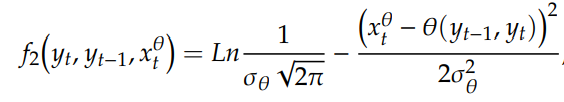

where xθt is the orientation of two consecutive observations, θ(yt−1, yt) is the orientation between two consecutive state points, and σ2θ is the variance of the orientation in the observation data.

## Load Libraries

In [ ]:
import pandas as pd 
from matplotlib import image
from matplotlib import pyplot as plt
from math import cos, asin, sqrt, pi, atan2 

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
rel_loc="drive/MyDrive/FYP/MyFolder/CRF-2/Part-1/" 

## Data Preprocessing

Here are units we use,

* location coordinates (x,y) : In pixels
* angle : radian
* distance - meter
* velocity - meter per second

### Prepare Floorplan

For this we use Lougheed Floorplan

2.5 Pixels = 1 m

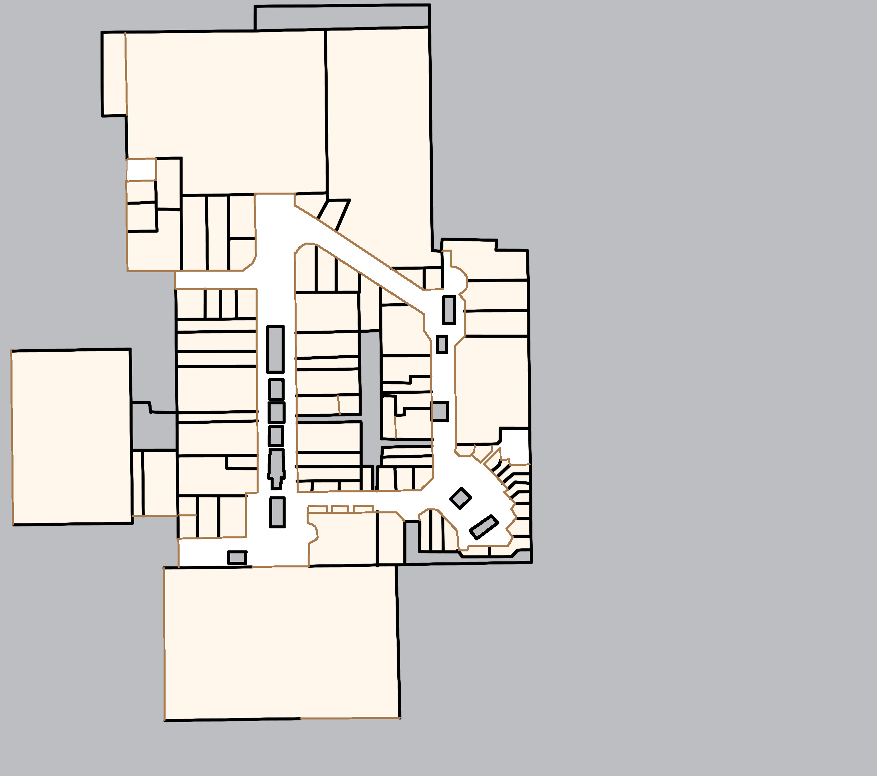

Here are the constrains,

Coordinate Center - (TOP LEFT, LR-> X+, TB -> Y+)

* Top Left (TL) - (0,0) in pixels, (49.252463,-122.897553) in Lat,Lon
* Bottom Left (BL) - (0,776) in pixels, (49.249681,-122.897553) in Lat,Lon
* Top Right (TR) - (887,0) in pixels, (49.252463,-122.892735) in Lat,Lon
* Bottom Right (BR) - (887,776) in pixels, (49.249681,-122.892735) in Lat,Lon

Now Let's load data we have. For this we use Fusion Location Provider's Data. (Which is in file FLP)

Load Data Set 1

In [ ]:
dataset1 = pd.read_csv(rel_loc+"dataset1.csv") 
df1=pd.DataFrame(dataset1)
df1.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10
0,422.225000,49.250524,-122.896379,21.393999,35.099998,4.599998,150.599854,0.0,0.214251,0.0
1,423.342410,49.250518,-122.896356,20.046000,35.099998,4.599998,121.818413,0.0,0.621120,0.0
2,424.343861,49.250517,-122.896350,19.625999,35.099998,4.599998,114.648056,0.0,0.525259,0.0
3,425.345205,49.250519,-122.896352,18.134001,35.099998,4.599998,105.172920,0.0,0.267578,0.0
4,426.340767,49.250519,-122.896351,17.996000,35.099998,4.599998,101.856239,0.0,0.194385,0.0


Load Data Set 2

In [ ]:
dataset2 = pd.read_csv(rel_loc+"dataset2.csv") 
df2=pd.DataFrame(dataset2)
df2.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10
0,4214.342792,49.251212,-122.896010,8.834,39.699997,4.700001,97.656136,0,0.000982,0.0
1,4215.344235,49.251207,-122.896008,8.408,39.699997,4.700001,95.627380,0,0.001220,0.0
2,4216.343776,49.251202,-122.896005,7.797,39.699997,4.700001,96.607895,0,0.001325,0.0
3,4216.973000,49.251198,-122.896002,7.536,35.099998,4.700001,95.984741,0,0.002083,0.0
4,4218.344638,49.251190,-122.896000,7.042,35.099998,4.700001,130.190704,0,0.000306,0.0


Concat Two Datasets

In [ ]:
df_merged=pd.concat([df1,df2])
df_merged.reset_index(inplace=True, drop=True)
df_merged.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10
0,422.225000,49.250524,-122.896379,21.393999,35.099998,4.599998,150.599854,0.0,0.214251,0.0
1,423.342410,49.250518,-122.896356,20.046000,35.099998,4.599998,121.818413,0.0,0.621120,0.0
2,424.343861,49.250517,-122.896350,19.625999,35.099998,4.599998,114.648056,0.0,0.525259,0.0
3,425.345205,49.250519,-122.896352,18.134001,35.099998,4.599998,105.172920,0.0,0.267578,0.0
4,426.340767,49.250519,-122.896351,17.996000,35.099998,4.599998,101.856239,0.0,0.194385,0.0


Get Dataframe Informations

In [ ]:
print(df1.shape[0])
print(df2.shape[0])
print(df_merged.shape[0])

986
747
1733


Select Only required data

In [ ]:
sub_df=df_merged[['Column1','Column2','Column3']]
sub_df = sub_df.rename(columns={'Column1': 'TimeStamp', 'Column2': 'Latitude','Column3':'Longitude'})
print(sub_df.shape[0])
sub_df.head()

1733


,TimeStamp,Latitude,Longitude
0,422.225000,49.250524,-122.896379
1,423.342410,49.250518,-122.896356
2,424.343861,49.250517,-122.896350
3,425.345205,49.250519,-122.896352
4,426.340767,49.250519,-122.896351


However we can't deal with Latitude and Longitude, We have to convert it to pixels or meters.

In [ ]:
# Calculate X direction,
# X direction -- Longitude
# X's Plus direction = Longitude's Plus Direction

# Calculate Y direction,
# Y direction -- Latitude
# Y's Plus direction = Latitude's Negative Direction

X_0_in_longitude=-122.897553
Y_0_in_latitude=49.252463
pixelspermeter=2.5
number_of_node_in_graph=30

# Distance between Two Lat,Lon


def distanceLatLonInMeters(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742000 * asin(sqrt(a))

x_dir_pixels=[]
y_dir_pixels=[]
x_dir_meters=[]
y_dir_meters=[]

for tuple in sub_df.itertuples():
    meters_in_x_direction=abs(distanceLatLonInMeters(Y_0_in_latitude,X_0_in_longitude,Y_0_in_latitude,tuple[3]))
    meters_in_y_direction=abs(distanceLatLonInMeters(Y_0_in_latitude,X_0_in_longitude,tuple[2],X_0_in_longitude))
    
    pixels_in_x_direction=round(meters_in_x_direction*2.5)
    pixels_in_y_direction=round(meters_in_y_direction*2.5)
    
    x_dir_pixels.append(pixels_in_x_direction)
    y_dir_pixels.append(pixels_in_y_direction)
    
    x_dir_meters.append(meters_in_x_direction)
    y_dir_meters.append(meters_in_y_direction)
    
    ##print(pixels_in_x_direction,pixels_in_y_direction,meters_in_x_direction,meters_in_y_direction)
    
updated_df=sub_df.copy()
updated_df["Pixels In X Direction"] = x_dir_pixels
updated_df["Pixels In Y Direction"] = y_dir_pixels
updated_df["Meters In X Direction"] = x_dir_meters
updated_df["Meters In Y Direction"] = y_dir_meters

Let's see updated dataframe

In [ ]:
updated_df.head()

,TimeStamp,Latitude,Longitude,Pixels In X Direction,Pixels In Y Direction,Meters In X Direction,Meters In Y Direction
0,422.225000,49.250524,-122.896379,213,539,85.208858,215.606966
1,423.342410,49.250518,-122.896356,217,541,86.878209,216.274132
2,424.343861,49.250517,-122.896350,218,541,87.313688,216.385327
3,425.345205,49.250519,-122.896352,218,540,87.168528,216.162941
4,426.340767,49.250519,-122.896351,218,540,87.241094,216.162941


Load Image and Mark Visited Areas

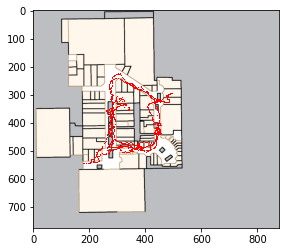

In [ ]:
floorplan0 = image.imread(rel_loc+'lougheed_00.png')
plt.imshow(floorplan0)
for row in updated_df.itertuples():
    plt.plot(row[4],row[5] , marker=',', color="red")
plt.savefig('visited_areas.png', bbox_inches='tight')
plt.show()

Now We can see that the area where measurements are taken

Now let's select some points to create graphs. In here we should **create several connected graph and give them unique graph ids**. However, the map we selected contains only one connected graph.

In [ ]:
graph=[{'nodeid': 0, 'x_dir_pixels': 392, 'y_dir_pixels': 285, 'connected_graph_id': 'G1'}, {'nodeid': 1, 'x_dir_pixels': 283, 'y_dir_pixels': 353, 'connected_graph_id': 'G1'}, {'nodeid': 2, 'x_dir_pixels': 445, 'y_dir_pixels': 357, 'connected_graph_id': 'G1'}, {'nodeid': 3, 'x_dir_pixels': 447, 'y_dir_pixels': 442, 'connected_graph_id': 'G1'}, {'nodeid': 4, 'x_dir_pixels': 280, 'y_dir_pixels': 270, 'connected_graph_id': 'G1'}, {'nodeid': 5, 'x_dir_pixels': 308, 'y_dir_pixels': 228, 'connected_graph_id': 'G1'}, {'nodeid': 6, 'x_dir_pixels': 283, 'y_dir_pixels': 415, 'connected_graph_id': 'G1'}, {'nodeid': 7, 'x_dir_pixels': 260, 'y_dir_pixels': 550, 'connected_graph_id': 'G1'}, {'nodeid': 8, 'x_dir_pixels': 265, 'y_dir_pixels': 493, 'connected_graph_id': 'G1'}, {'nodeid': 9, 'x_dir_pixels': 269, 'y_dir_pixels': 436, 'connected_graph_id': 'G1'}, {'nodeid': 10, 'x_dir_pixels': 261, 'y_dir_pixels': 513, 'connected_graph_id': 'G1'}, {'nodeid': 11, 'x_dir_pixels': 258, 'y_dir_pixels': 470, 'connected_graph_id': 'G1'}, {'nodeid': 12, 'x_dir_pixels': 390, 'y_dir_pixels': 500, 'connected_graph_id': 'G1'}, {'nodeid': 13, 'x_dir_pixels': 341, 'y_dir_pixels': 500, 'connected_graph_id': 'G1'}, {'nodeid': 14, 'x_dir_pixels': 263, 'y_dir_pixels': 449, 'connected_graph_id': 'G1'}, {'nodeid': 15, 'x_dir_pixels': 266, 'y_dir_pixels': 366, 'connected_graph_id': 'G1'}, {'nodeid': 16, 'x_dir_pixels': 275, 'y_dir_pixels': 319, 'connected_graph_id': 'G1'}, {'nodeid': 17, 'x_dir_pixels': 282, 'y_dir_pixels': 463, 'connected_graph_id': 'G1'}, {'nodeid': 18, 'x_dir_pixels': 282, 'y_dir_pixels': 306, 'connected_graph_id': 'G1'}, {'nodeid': 19, 'x_dir_pixels': 440, 'y_dir_pixels': 500, 'connected_graph_id': 'G1'}, {'nodeid': 20, 'x_dir_pixels': 286, 'y_dir_pixels': 331, 'connected_graph_id': 'G1'}, {'nodeid': 21, 'x_dir_pixels': 283, 'y_dir_pixels': 332, 'connected_graph_id': 'G1'}, {'nodeid': 22, 'x_dir_pixels': 285, 'y_dir_pixels': 369, 'connected_graph_id': 'G1'}, {'nodeid': 23, 'x_dir_pixels': 230, 'y_dir_pixels': 540, 'connected_graph_id': 'G1'}, {'nodeid': 24, 'x_dir_pixels': 438, 'y_dir_pixels': 323, 'connected_graph_id': 'G1'}, {'nodeid': 25, 'x_dir_pixels': 289, 'y_dir_pixels': 390, 'connected_graph_id': 'G1'}, {'nodeid': 26, 'x_dir_pixels': 329, 'y_dir_pixels': 240, 'connected_graph_id': 'G1'}, {'nodeid': 27, 'x_dir_pixels': 200, 'y_dir_pixels': 550, 'connected_graph_id': 'G1'}, {'nodeid': 28, 'x_dir_pixels': 371, 'y_dir_pixels': 265, 'connected_graph_id': 'G1'}, {'nodeid': 29, 'x_dir_pixels': 282, 'y_dir_pixels': 242, 'connected_graph_id': 'G1'}]
graphtable=pd.DataFrame(graph)
graphtable['x_dir_meters'] = graphtable.apply(lambda row: row['x_dir_pixels']/2.5, axis=1)
graphtable['y_dir_meters'] = graphtable.apply(lambda row: row['y_dir_pixels']/2.5, axis=1)
graphtable = graphtable[["nodeid","x_dir_pixels","y_dir_pixels","x_dir_meters","y_dir_meters","connected_graph_id"]]
graphtable

,nodeid,x_dir_pixels,y_dir_pixels,x_dir_meters,y_dir_meters,connected_graph_id
0,0,392,285,156.8,114.0,G1
1,1,283,353,113.2,141.2,G1
2,2,445,357,178.0,142.8,G1
3,3,447,442,178.8,176.8,G1
4,4,280,270,112.0,108.0,G1
5,5,308,228,123.2,91.2,G1
6,6,283,415,113.2,166.0,G1
7,7,260,550,104.0,220.0,G1
8,8,265,493,106.0,197.2,G1
9,9,269,436,107.6,174.4,G1


Let's draw graph,

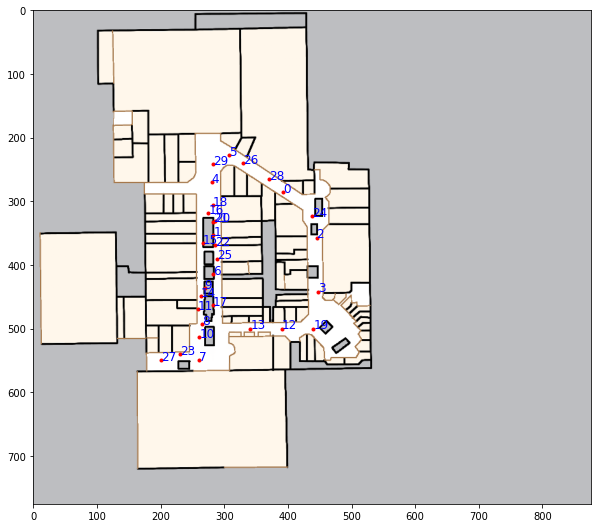

In [ ]:
floorplan1 = image.imread(rel_loc+'lougheed_00.png')
plt.figure(figsize = (10,10))
plt.imshow(floorplan1)
for row in graphtable.to_dict('records'):
    plt.plot(row["x_dir_pixels"],row["y_dir_pixels"] , marker='.', color="red")
    plt.text(row["x_dir_pixels"],row["y_dir_pixels"] , str(row["nodeid"]), color="blue", fontsize=12)
plt.show()

### Define Reachable

In [ ]:
# Node ID , Reachable IDs
reachable={}
for from_row in graphtable.to_dict('records'):
    from_node =  from_row["nodeid"]
    from_x = from_row["x_dir_meters"]
    from_y = from_row["y_dir_meters"]
    distances = {}
    for to_row in graphtable.to_dict('records') :
        to_node = to_row["nodeid"]
        if from_node == to_node :
            continue
        to_x = to_row["x_dir_meters"]
        to_y = to_row["y_dir_meters"]
        distance= sqrt((to_x-from_x)**2 + (to_y-from_y)**2)
        distances[to_node]=distance
    nearest = sorted(distances, key=distances.get)[:2]
    reachable[from_node]=nearest
print(reachable)    

{0: [28, 24], 1: [22, 21], 2: [24, 3], 3: [19, 12], 4: [29, 18], 5: [26, 29], 6: [9, 25], 7: [23, 10], 8: [10, 11], 9: [14, 6], 10: [8, 7], 11: [14, 8], 12: [13, 19], 13: [12, 17], 14: [9, 11], 15: [22, 1], 16: [18, 21], 17: [14, 11], 18: [16, 20], 19: [12, 3], 20: [21, 16], 21: [20, 16], 22: [1, 15], 23: [7, 27], 24: [2, 0], 25: [22, 6], 26: [5, 29], 27: [23, 7], 28: [0, 26], 29: [4, 5]}


### Add reachable to columns

In [ ]:
reachable_1 =[]
reachable_2 =[]
#reachable_3 =[]

for value in reachable.values():
    reachable_1.append(value[0])
    reachable_2.append(value[1])
   # reachable_3.append(value[2])

graphtable["reachable_1"]=reachable_1
graphtable["reachable_2"]=reachable_2
#graphtable["reachable_3"]=reachable_3
graphtable = graphtable[["nodeid","x_dir_pixels","y_dir_pixels","x_dir_meters","y_dir_meters","reachable_1","reachable_2","connected_graph_id"]]
graphtable

,nodeid,x_dir_pixels,y_dir_pixels,x_dir_meters,y_dir_meters,reachable_1,reachable_2,connected_graph_id
0,0,392,285,156.8,114.0,28,24,G1
1,1,283,353,113.2,141.2,22,21,G1
2,2,445,357,178.0,142.8,24,3,G1
3,3,447,442,178.8,176.8,19,12,G1
4,4,280,270,112.0,108.0,29,18,G1
5,5,308,228,123.2,91.2,26,29,G1
6,6,283,415,113.2,166.0,9,25,G1
7,7,260,550,104.0,220.0,23,10,G1
8,8,265,493,106.0,197.2,10,11,G1
9,9,269,436,107.6,174.4,14,6,G1


### Draw Graph

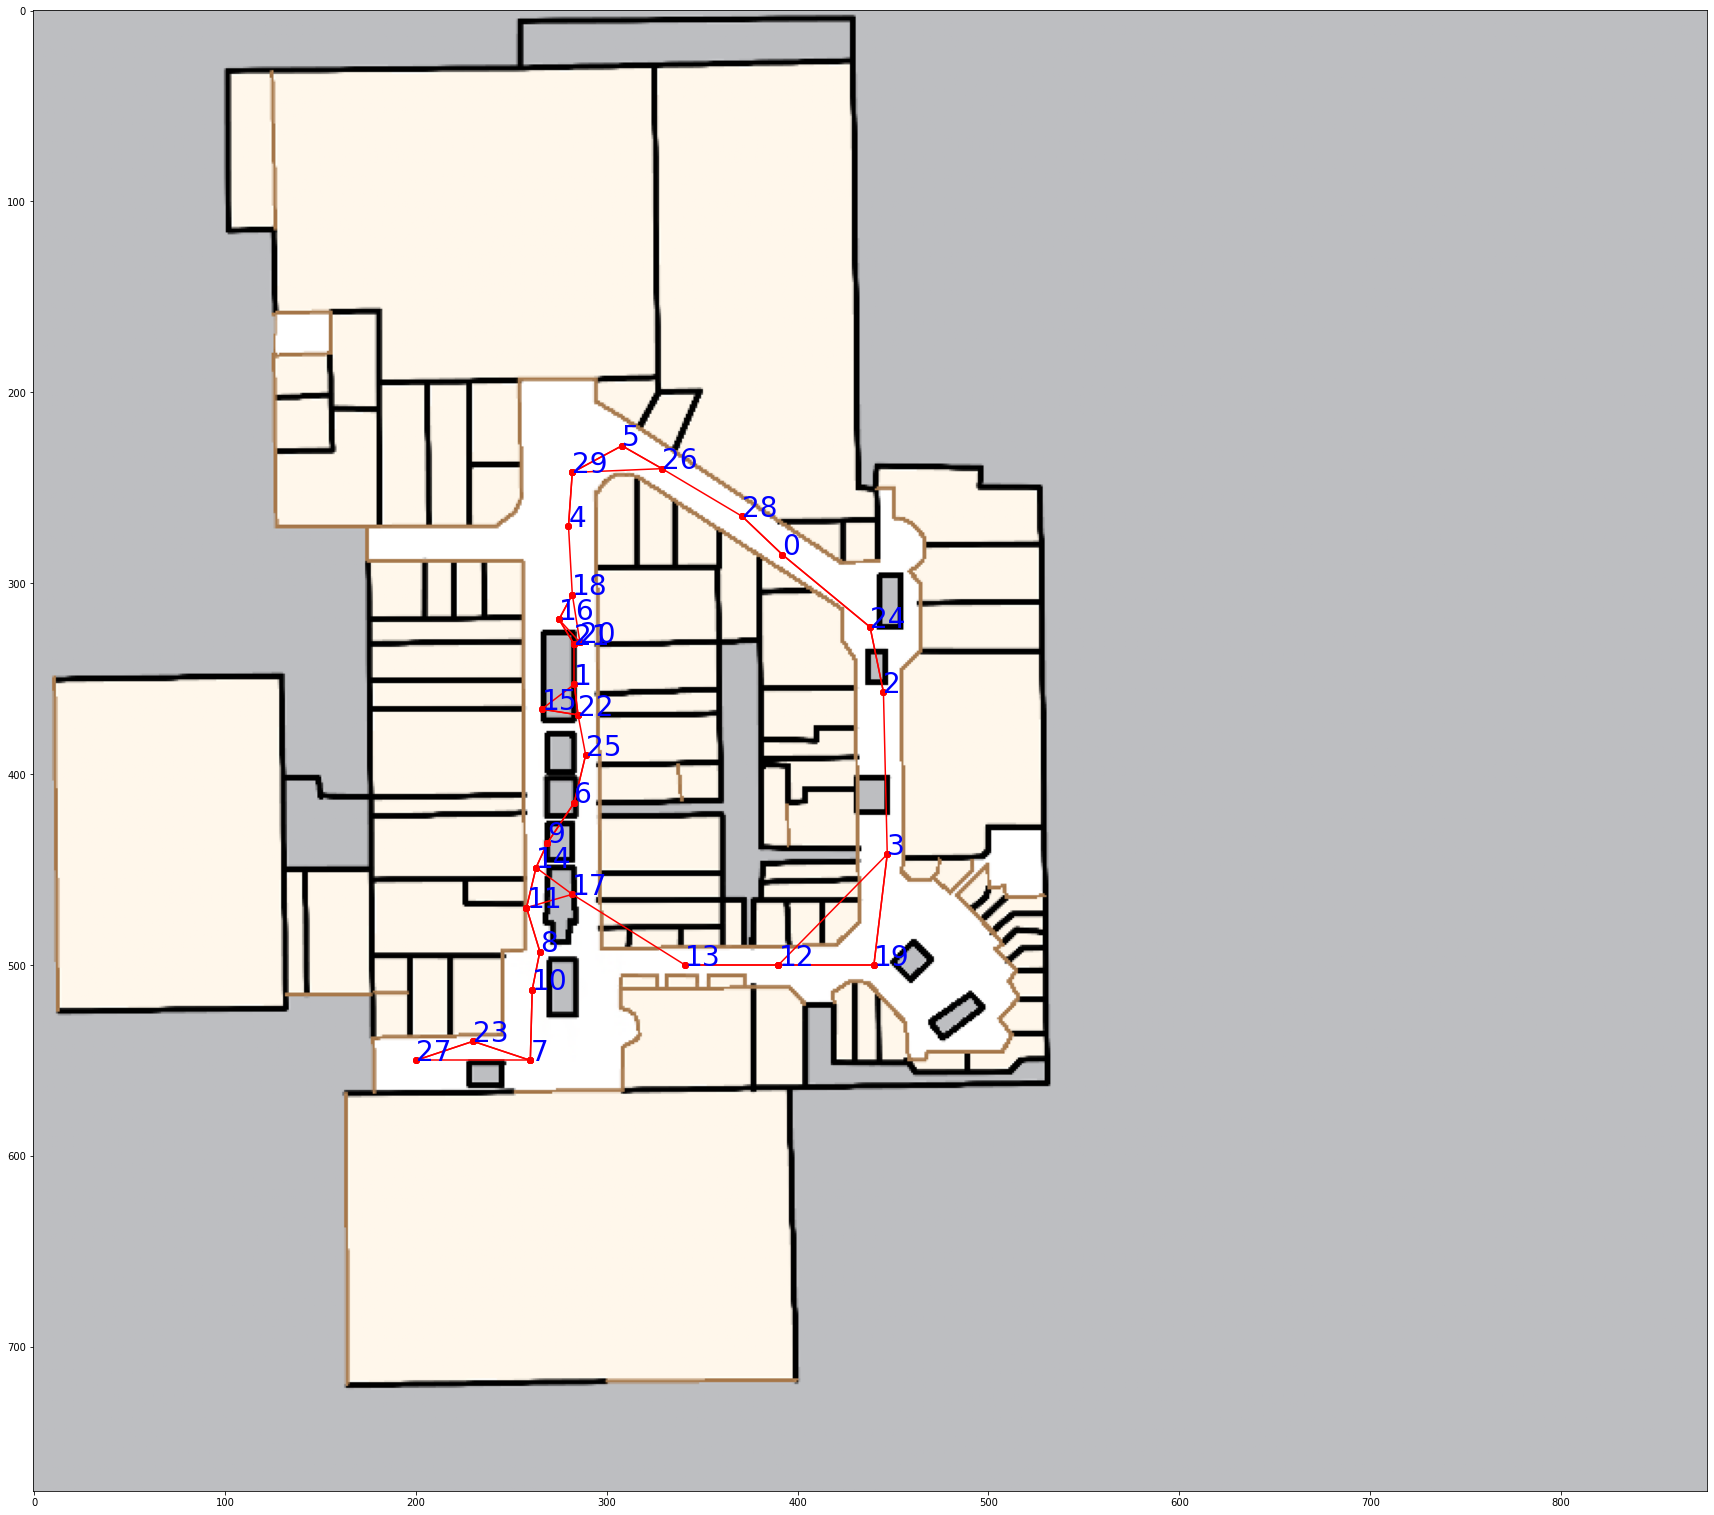

In [ ]:
floorplan1 = image.imread(rel_loc+'lougheed_00.png')
plt.figure(figsize = (30,30))
plt.imshow(floorplan1)
for row in graphtable.to_dict('records'):
    
    reachable_ids=[row["reachable_1"], row["reachable_2"]]
    for reachablerow in graphtable.to_dict('records'):
        if reachablerow["nodeid"] in reachable_ids:
            plt.plot([row["x_dir_pixels"], reachablerow["x_dir_pixels"]],[row["y_dir_pixels"], reachablerow["y_dir_pixels"]],'ro-')
    
    plt.plot(row["x_dir_pixels"],row["y_dir_pixels"] , marker='.', color="red")
    plt.text(row["x_dir_pixels"],row["y_dir_pixels"] , str(row["nodeid"]), color="blue", fontsize=28)
plt.savefig('floor_plan_graph.png', bbox_inches='tight')
plt.show()

Now we have successfully created a graph for the floor plan

### Prepare DataSet

Let's revisit updated_df

In [ ]:
updated_df

,TimeStamp,Latitude,Longitude,Pixels In X Direction,Pixels In Y Direction,Meters In X Direction,Meters In Y Direction
0,422.225000,49.250524,-122.896379,213,539,85.208858,215.606966
1,423.342410,49.250518,-122.896356,217,541,86.878209,216.274132
2,424.343861,49.250517,-122.896350,218,541,87.313688,216.385327
3,425.345205,49.250519,-122.896352,218,540,87.168528,216.162941
4,426.340767,49.250519,-122.896351,218,540,87.241094,216.162941
...,...,...,...,...,...,...,...
1728,5139.091000,49.250493,-122.896482,194,548,77.733134,219.053999
1729,5139.592000,49.250492,-122.896509,189,548,75.773474,219.165203
1730,5140.198000,49.250492,-122.896525,187,548,74.612179,219.165203
1731,5140.773000,49.250491,-122.896546,183,548,73.088002,219.276392


Denfine Helper Functions

In [ ]:
def calcVelocityVal(prev_row,row):
    distance=sqrt((row[6]-prev_row[6])**2+(row[7]-prev_row[7])**2)
    timediff=row[1]-prev_row[1]
    return distance/timediff

def calcVelocityAngle(prev_row,row):
    return atan2(row[7]-prev_row[7], row[6]-prev_row[6])

def calcNearestState(row):
    
    currentNearestStateID=None
    minDistance=float('inf')
    
    for points in graph:
        
        stateid=points["nodeid"]
        distanceToState=sqrt((points['y_dir_pixels']-row[5])**2+(points['x_dir_pixels']-row[4])**2)
        
        if distanceToState<=minDistance:
            minDistance=distanceToState
            currentNearestStateID=stateid
    return currentNearestStateID
    

Now let's calculate velocities and nearest states

In [ ]:
velocity_value=["N/A"]
velocity_angle=["N/A"]
nearest_state=["N/A"]
isValid=[]
prev_row=None

for row in updated_df.itertuples():
   
    # Process First Value
    if row[0]==0:
        prev_row=row
        isValid.append(0)
        continue
        
    timediff=row[1]-prev_row[1]
    if timediff>=2:
        isValid.append(0)
    else:
        isValid.append(1)
    
        
    velocity_value.append(calcVelocityVal(prev_row,row))
    velocity_angle.append(calcVelocityAngle(prev_row,row))
    nearest_state.append(calcNearestState(row))
    prev_row=row
    
updated_df["Velocity_Value"]=velocity_value
updated_df["Velocity_Angle"]=velocity_angle
updated_df["Nearest_State"]=nearest_state
updated_df["isValid"]=isValid

Let's check new dataframe

In [ ]:
updated_df

,TimeStamp,Latitude,Longitude,Pixels In X Direction,Pixels In Y Direction,Meters In X Direction,Meters In Y Direction,Velocity_Value,Velocity_Angle,Nearest_State,isValid
0,422.225000,49.250524,-122.896379,213,539,85.208858,215.606966,N/A,N/A,N/A,0
1,423.342410,49.250518,-122.896356,217,541,86.878209,216.274132,1.608839,0.38021,23,1
2,424.343861,49.250517,-122.896350,218,541,87.313688,216.385327,0.448801,0.249999,23,1
3,425.345205,49.250519,-122.896352,218,540,87.168528,216.162941,0.265213,-2.149096,23,1
4,426.340767,49.250519,-122.896351,218,540,87.241094,216.162941,0.07289,0.0,23,1
...,...,...,...,...,...,...,...,...,...,...,...
1728,5139.091000,49.250493,-122.896482,194,548,77.733134,219.053999,1.150133,-3.056677,27,1
1729,5139.592000,49.250492,-122.896509,189,548,75.773474,219.165203,3.917791,3.084907,27,1
1730,5140.198000,49.250492,-122.896525,187,548,74.612179,219.165203,1.916328,3.141593,27,1
1731,5140.773000,49.250491,-122.896546,183,548,73.088002,219.276392,2.657787,3.068772,27,1


Now lets created filtered dataframe which only contains, required columns and valid values

In [ ]:
filtered_df=updated_df.copy()
filtered_df=filtered_df[filtered_df['isValid'] == 1]
filtered_df=filtered_df[["TimeStamp","Meters In X Direction","Meters In Y Direction","Velocity_Value","Velocity_Angle","Nearest_State"]]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df.head()

,TimeStamp,Meters In X Direction,Meters In Y Direction,Velocity_Value,Velocity_Angle,Nearest_State
0,423.342410,86.878209,216.274132,1.608839,0.38021,23
1,424.343861,87.313688,216.385327,0.448801,0.249999,23
2,425.345205,87.168528,216.162941,0.265213,-2.149096,23
3,426.340767,87.241094,216.162941,0.07289,0.0,23
4,427.343544,87.241094,216.162941,0.0,0.0,23


Let's check first index of second data set

In [ ]:
print(filtered_df.loc[873:877])

       TimeStamp  Meters In X Direction  Meters In Y Direction Velocity_Value  \
873  1724.342825             104.732868             145.887755       0.494914   
874  1725.344916             105.531256             146.888500       1.277529   
875  4215.344235             112.136031             139.660827       0.573771   
876  4216.343776             112.353760             140.216800       0.597361   
877  4216.973000             112.571511             140.661598       0.787062   

    Velocity_Angle Nearest_State  
873       0.743327            15  
874       0.897402            15  
875       1.315392             1  
876       1.197537             1  
877       1.115543             1  


In [ ]:
first_index_of_second_set=875

Now Let's create a dataset

In [ ]:
data=[]
for row in filtered_df.loc[19:first_index_of_second_set-1].itertuples():
    datadict={}
    start_x = filtered_df.loc[row[0]-19][1]
    start_y = filtered_df.loc[row[0]-19][2]
    datadict["startX_in_meters"]=start_x
    datadict["startY_in_meters"]=start_y
    i=0
    for subrow in filtered_df.loc[row[0]-19:row[0]].itertuples():
        datadict["velocity_value_"+str(i+1)]=subrow[4]
        i+=1
    j=0
    for subrow in filtered_df.loc[row[0]-19:row[0]].itertuples():
        datadict["velocity_angle_"+str(j+1)]=subrow[5]
        j+=1
    k=0
    for subrow in filtered_df.loc[row[0]-19:row[0]].itertuples():
        datadict["state_"+str(k+1)]=subrow[6]
        k+=1
    data.append(datadict)

prepared_dataset1=pd.DataFrame(data)
prepared_dataset1

,startX_in_meters,startY_in_meters,velocity_value_1,velocity_value_2,velocity_value_3,velocity_value_4,velocity_value_5,velocity_value_6,velocity_value_7,velocity_value_8,...,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20
0,86.878209,216.274132,1.608839,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,...,23,23,23,23,23,23,23,23,23,23
1,87.313688,216.385327,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,...,23,23,23,23,23,23,23,23,23,23
2,87.168528,216.162941,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,...,23,23,23,23,23,23,23,23,23,23
3,87.241094,216.162941,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,...,23,23,23,23,23,23,23,23,23,23
4,87.241094,216.162941,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,0.108577,...,23,23,23,23,23,23,23,23,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,108.869936,146.999699,0.716452,1.070863,0.316556,0.332816,0.379091,0.717360,0.866805,0.687368,...,15,15,15,15,15,15,15,15,15,15
852,108.507033,146.443721,1.070863,0.316556,0.332816,0.379091,0.717360,0.866805,0.687368,0.868035,...,15,15,15,15,15,15,15,15,15,15
853,108.361861,146.221317,0.316556,0.332816,0.379091,0.717360,0.866805,0.687368,0.868035,1.374921,...,15,15,15,15,15,15,15,15,15,15
854,107.998976,146.221317,0.332816,0.379091,0.717360,0.866805,0.687368,0.868035,1.374921,1.548056,...,15,15,15,15,15,15,15,15,15,15


In [ ]:
data=[]
for row in filtered_df.loc[first_index_of_second_set:].itertuples():
    datadict={}
    start_x = filtered_df.loc[row[0]-19][1]
    start_y = filtered_df.loc[row[0]-19][2]
    datadict["startX_in_meters"]=start_x
    datadict["startY_in_meters"]=start_y
    i=0
    for subrow in filtered_df.loc[row[0]-19:row[0]].itertuples():
        datadict["velocity_value_"+str(i+1)]=subrow[4]
        i+=1
    j=0
    for subrow in filtered_df.loc[row[0]-19:row[0]].itertuples():
        datadict["velocity_angle_"+str(j+1)]=subrow[5]
        j+=1
    k=0
    for subrow in filtered_df.loc[row[0]-19:row[0]].itertuples():
        datadict["state_"+str(k+1)]=subrow[6]
        k+=1
    data.append(datadict)

prepared_dataset2=pd.DataFrame(data)
prepared_dataset2

,startX_in_meters,startY_in_meters,velocity_value_1,velocity_value_2,velocity_value_3,velocity_value_4,velocity_value_5,velocity_value_6,velocity_value_7,velocity_value_8,...,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20
0,107.055423,146.110143,0.717360,0.866805,0.687368,0.868035,1.374921,1.548056,1.219290,0.698860,...,15,15,15,15,15,15,15,15,15,1
1,106.547363,146.554919,0.866805,0.687368,0.868035,1.374921,1.548056,1.219290,0.698860,0.453633,...,15,15,15,15,15,15,15,15,1,1
2,106.039313,147.222090,0.687368,0.868035,1.374921,1.548056,1.219290,0.698860,0.453633,0.648189,...,15,15,15,15,15,15,15,1,1,1
3,105.894149,146.777309,0.868035,1.374921,1.548056,1.219290,0.698860,0.453633,0.648189,0.566566,...,15,15,15,15,15,15,1,1,1,1
4,106.039313,145.887755,1.374921,1.548056,1.219290,0.698860,0.453633,0.648189,0.566566,0.362281,...,15,15,15,15,15,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,82.450823,214.050235,0.263278,0.427974,0.170369,0.143115,0.106922,0.286135,0.841608,0.420555,...,27,27,27,27,27,27,27,27,27,27
674,82.305671,214.272627,0.427974,0.170369,0.143115,0.106922,0.286135,0.841608,0.420555,0.410061,...,27,27,27,27,27,27,27,27,27,27
675,82.233092,214.495019,0.170369,0.143115,0.106922,0.286135,0.841608,0.420555,0.410061,0.334680,...,27,27,27,27,27,27,27,27,27,27
676,82.160495,214.606212,0.143115,0.106922,0.286135,0.841608,0.420555,0.410061,0.334680,0.441781,...,27,27,27,27,27,27,27,27,27,27


In [ ]:
final_prepared_dataset=pd.concat([prepared_dataset1,prepared_dataset2])
final_prepared_dataset.reset_index(inplace=True, drop=True)
final_prepared_dataset

,startX_in_meters,startY_in_meters,velocity_value_1,velocity_value_2,velocity_value_3,velocity_value_4,velocity_value_5,velocity_value_6,velocity_value_7,velocity_value_8,...,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,state_19,state_20
0,86.878209,216.274132,1.608839,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,...,23,23,23,23,23,23,23,23,23,23
1,87.313688,216.385327,0.448801,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,...,23,23,23,23,23,23,23,23,23,23
2,87.168528,216.162941,0.265213,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,...,23,23,23,23,23,23,23,23,23,23
3,87.241094,216.162941,0.072890,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,...,23,23,23,23,23,23,23,23,23,23
4,87.241094,216.162941,0.000000,0.072421,2.113376,0.826399,0.069784,0.102970,0.000000,0.108577,...,23,23,23,23,23,23,23,23,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,82.450823,214.050235,0.263278,0.427974,0.170369,0.143115,0.106922,0.286135,0.841608,0.420555,...,27,27,27,27,27,27,27,27,27,27
1530,82.305671,214.272627,0.427974,0.170369,0.143115,0.106922,0.286135,0.841608,0.420555,0.410061,...,27,27,27,27,27,27,27,27,27,27
1531,82.233092,214.495019,0.170369,0.143115,0.106922,0.286135,0.841608,0.420555,0.410061,0.334680,...,27,27,27,27,27,27,27,27,27,27
1532,82.160495,214.606212,0.143115,0.106922,0.286135,0.841608,0.420555,0.410061,0.334680,0.441781,...,27,27,27,27,27,27,27,27,27,27


### Save Outcomes

Now let's save out results

In [ ]:
graphtable.to_csv("floor_plan_graph.csv", encoding='utf-8', index=False)
final_prepared_dataset.to_csv("final_prepared_dataset.csv", encoding='utf-8', index=False)